# Data Wrangling

In [118]:
# Importing required libraries
import pandas as pd
import numpy as np
import tweepy
import requests
import re
import json
import matplotlib.pyplot as plt
import datetime
import os
import seaborn as sns
from tweepy import OAuthHandler
from timeit import default_timer as timer
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## 1. Data Gathering

In [3]:
# Loading twitter-archive-enhanced.csv into our notebook
archive = pd.read_csv('twitter-archive-enhanced.csv')

In [2]:
# Downloading and saving the image prediction data using Requests
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
file_name = url.split('/')[-1]
response = requests.get(url)

if not os.path.isfile(file_name):
    with open(file_name, 'wb') as f:
        f.write(response.content)

In [4]:
# Loading image-prediction.csv into our notebook
image = pd.read_csv('image-predictions.tsv', sep='\t')

In [5]:
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'lQ7MeLvz9NoQhkfNscShwiBVh'
consumer_secret = 'VnxxlYS4e2fOIj4L4kTBAF5QT412pkm0r6tXRlfwijDFaT6KP0'
access_token = '1350632506970796032-6wW22blELltHJ0Io99XbX1cTeqT0qD'
access_secret = 'vfDkRUv0wd0wAQ3GdNuFDH13aXsIb99cb3l3MDx9TcjQc'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [6]:
# Experimenting to extract one tweet's id information after creating an API object
exp_tweet = api.get_status(archive.tweet_id[1000], tweet_mode = 'extended')
content = exp_tweet._json
print(content)

TweepError: Failed to send request: HTTPSConnectionPool(host='api.twitter.com', port=443): Max retries exceeded with url: /1.1/statuses/show.json?id=747963614829678593&tweet_mode=extended (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001AB04D35310>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))

In [ ]:
# Checking the keys of the test tweet
content.keys()

In [ ]:
# Getting the retweet_count, id and favorite_count for the test tweet
(exp_tweet.retweet_count, exp_tweet.id, exp_tweet.favorite_count)

In [ ]:
errors = []
if not os.path.isfile('tweet_json.txt'):
    # create the file and write on it
    with open('tweet_json.txt', 'w') as file:
        for tweet_id in archive['tweet_id']:
            try:
                status = api.get_status(tweet_id, wait_on_rate_limit=True, wait_on_rate_limit_notify=True, tweet_mode='extended')
                json.dump(status._json, file)
                file.write('\n')
            except Exception as e:
                print("Error on tweet id {}".format(tweet_id) + ";" + str(e))
                errors.append(tweet_id)

In [ ]:
# Number of tweets that don't have status
len(errors)

In [7]:
# Storing tweets in a list
tweets_list = []
count = 0
with open('tweet_json.txt', 'r') as f:
    for line in f:
        tweet = json.loads(line)
        tweets_list.append(tweet)

In [8]:
# Creating api_df with columns: 'tweet_id', 'retweet_count' and 'favorite_count'
api = {'tweet_id': [], 'retweet_count': [], 'favorite_count': []}
for i in range(len(tweets_list)):
    api['tweet_id'].append(tweets_list[i]['id'])
    api['retweet_count'].append(tweets_list[i]['retweet_count'])
    api['favorite_count'].append(tweets_list[i]['favorite_count'])
api_df = pd.DataFrame(api)
api_df.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,7417,35161
1,892177421306343426,5517,30423
2,891815181378084864,3640,22875
3,891689557279858688,7592,38443
4,891327558926688256,8166,36692


## 2. Data Assessing

In [9]:
# Visualize archive data frame
archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [10]:
# informations about archive
archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [11]:
# Statistics information about archive ratings
archive[['rating_numerator', 'rating_denominator']].describe()

,rating_numerator,rating_denominator
count,2356.000000,2356.000000
mean,13.126486,10.455433
std,45.876648,6.745237
min,0.000000,0.000000
25%,10.000000,10.000000
50%,11.000000,10.000000
75%,12.000000,10.000000
max,1776.000000,170.000000


In [12]:
# sources of archives
archive.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [13]:
# archive texts
archive.text.value_counts()

After so many requests... here you go.\n\nGood dogg. 420/10 https://t.co/yfAAo1gdeY                                                                                    1
This is an Iraqi Speed Kangaroo. It is not a dog. Please only send in dogs. I'm very angry with all of you ...9/10 https://t.co/5qpBTTpgUt                             1
We normally don't rate marshmallows but this one appears to be flawlessly toasted so I'll make an exception. 10/10 https://t.co/D9jbbmPmos                             1
This is Dexter. He breaks hearts for a living. 11/10 h*ckin handsome af https://t.co/4DhSsC1W7S                                                                        1
Say hello to Oakley and Charlie. They're convinced that they each have their own stick. Nobody tell them. Both 12/10 https://t.co/J2AJdyxglH                           1
                                                                                                                                                           

In [14]:
# Urls of archive retweets
archive.expanded_urls.value_counts()

https://twitter.com/dog_rates/status/700747788515020802/photo/1                                                                                                                                    2
https://twitter.com/dog_rates/status/859196978902773760/video/1                                                                                                                                    2
https://www.gofundme.com/my-puppys-double-cataract-surgery,https://twitter.com/dog_rates/status/825026590719483904/photo/1,https://twitter.com/dog_rates/status/825026590719483904/photo/1         2
https://twitter.com/dog_rates/status/786963064373534720/photo/1                                                                                                                                    2
https://twitter.com/dog_rates/status/676936541936185344/photo/1                                                                                                                                    2
               

In [15]:
# denominators of archive rating_tweets
archive.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [16]:
# numerators of archive_ratings
archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [17]:
# Names of dogs
archive.name.value_counts()

None        745
a            55
Charlie      12
Lucy         11
Oliver       11
           ... 
Lupe          1
Evy           1
Fletcher      1
Jeffri        1
Sundance      1
Name: name, Length: 957, dtype: int64

In [18]:
# Number of puppers
archive.pupper.value_counts()

None      2099
pupper     257
Name: pupper, dtype: int64

In [19]:
# Number of doggos
archive.doggo.value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

In [20]:
# Number of floofers
archive.floofer.value_counts()

None       2346
floofer      10
Name: floofer, dtype: int64

In [21]:
# Number of puppoes
archive.puppo.value_counts()

None     2326
puppo      30
Name: puppo, dtype: int64

In [22]:
# columns of archive dataframe
archive.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

In [23]:
# Visualizing image predictions dataframe
image

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [24]:
# images information
image.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [25]:
# columns of image predictions dataframe
image.columns

Index(['tweet_id', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'],
      dtype='object')

In [26]:
# statistics of predictions of breeds of dogs
image[['p1_conf', 'p2_conf', 'p3_conf']].describe()

,p1_conf,p2_conf,p3_conf
count,2075.000000,2.075000e+03,2.075000e+03
mean,0.594548,1.345886e-01,6.032417e-02
std,0.271174,1.006657e-01,5.090593e-02
min,0.044333,1.011300e-08,1.740170e-10
25%,0.364412,5.388625e-02,1.622240e-02
50%,0.588230,1.181810e-01,4.944380e-02
75%,0.843855,1.955655e-01,9.180755e-02
max,1.000000,4.880140e-01,2.734190e-01


In [27]:
# tweets that have no images in archive
pd.merge(left=archive, right=image, on='tweet_id', how='left').query('img_num == "NaN"')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,8.860537e+17,19607400.0,2017-07-15 02:44:07 +0000,https://twitter.com/dog_rates/status/886053434...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35,885518971528720385,NaN,NaN,2017-07-13 15:19:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I have a new hero and his name is Howard. 14/1...,NaN,NaN,NaN,https://twitter.com/4bonds2carbon/status/88551...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42,884247878851493888,NaN,NaN,2017-07-10 03:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",OMG HE DIDN'T MEAN TO HE WAS JUST TRYING A LIT...,NaN,NaN,NaN,https://twitter.com/kaijohnson_19/status/88396...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2038,671550332464455680,6.715449e+17,4.196984e+09,2015-12-01 04:44:10 +0000,"<a href=""http://twitter.com/download/iphone"" r...",After 22 minutes of careful deliberation this ...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2149,669684865554620416,6.693544e+17,4.196984e+09,2015-11-26 01:11:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",After countless hours of research and hundreds...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2189,668967877119254528,6.689207e+17,2.143566e+07,2015-11-24 01:42:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",12/10 good shit Bubka\n@wane15,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2212,668587383441514497,NaN,NaN,2015-11-23 00:30:28 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",Never forget this vine. You will not stop watc...,NaN,NaN,NaN,https://vine.co/v/ea0OwvPTx9l,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
# tweets that have no images in API table
pd.merge(left=api_df, right=image, on='tweet_id', how='left')

,tweet_id,retweet_count,favorite_count,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,7417,35161,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1.0,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,5517,30423,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,3640,22875,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1.0,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,891689557279858688,7592,38443,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1.0,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
4,891327558926688256,8166,36692,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2.0,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2326,666049248165822465,38,94,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1.0,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
2327,666044226329800704,122,261,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1.0,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
2328,666033412701032449,39,107,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1.0,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
2329,666029285002620928,41,118,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1.0,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True


In [29]:
# tweets that are replies in archive table
replies = archive.query('in_reply_to_status_id != "NaN" and in_reply_to_user_id != "NaN"')
replies

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is res...,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Jack_Septic_Eye I'd need a few more pics to p...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2038,671550332464455680,6.715449e+17,4.196984e+09,2015-12-01 04:44:10 +0000,"<a href=""http://twitter.com/download/iphone"" r...",After 22 minutes of careful deliberation this ...,NaN,NaN,NaN,NaN,1,10,None,None,None,None,None
2149,669684865554620416,6.693544e+17,4.196984e+09,2015-11-26 01:11:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",After countless hours of research and hundreds...,NaN,NaN,NaN,NaN,11,10,None,None,None,None,None
2169,669353438988365824,6.678065e+17,4.196984e+09,2015-11-25 03:14:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tessa. She is also very pleased after ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/669353438...,10,10,Tessa,None,None,None,None
2189,668967877119254528,6.689207e+17,2.143566e+07,2015-11-24 01:42:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",12/10 good shit Bubka\n@wane15,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None


In [30]:
# tweets that are replies in image
pd.merge(left=replies, right=image, on='tweet_id')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,863079547188785154,6.671522e+17,4.196984e+09,2017-05-12 17:12:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Ladies and gentlemen... I found Pipsy. He may ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/863079547...,...,1,Lakeland_terrier,0.275242,True,Airedale,0.190569,True,teddy,0.102595,False
1,856526610513747968,8.558181e+17,4.196984e+09,2017-04-24 15:13:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...","THIS IS CHARLIE, MARK. HE DID JUST WANT TO SAY...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/856526610...,...,1,Old_English_sheepdog,0.798481,True,Tibetan_terrier,0.060602,True,standard_poodle,0.040722,True
2,844979544864018432,7.590995e+17,4.196984e+09,2017-03-23 18:29:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",PUPDATE: I'm proud to announce that Toby is 23...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/844979544...,...,3,tennis_ball,0.999281,False,racket,0.000370,False,Shetland_sheepdog,0.000132,True
3,802265048156610565,7.331095e+17,4.196984e+09,2016-11-25 21:37:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Like doggo, like pupper version 2. Both 11/10 ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/802265048...,...,1,Labrador_retriever,0.897162,True,beagle,0.016895,True,Rhodesian_ridgeback,0.012061,True
4,746906459439529985,7.468859e+17,4.196984e+09,2016-06-26 03:22:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...","PUPDATE: can't see any. Even if I could, I cou...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/746906459...,...,1,traffic_light,0.470708,False,fountain,0.199776,False,space_shuttle,0.064807,False
5,746818907684614144,6.914169e+17,4.196984e+09,2016-06-25 21:34:37 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Guys... Dog Jesus 2.0\n13/10 buoyant af https:...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/746818907...,...,1,dingo,0.175518,False,timber_wolf,0.133647,False,Ibizan_hound,0.101537,True
6,729838605770891264,7.291135e+17,4.196984e+09,2016-05-10 01:00:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...","""Challenge completed"" \n(pupgraded to 12/10) h...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/729838605...,...,1,stone_wall,0.758218,False,patio,0.074205,False,prison,0.013826,False
7,705786532653883392,7.032559e+17,4.196984e+09,2016-03-04 16:06:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Seriously, add us 🐶 11/10 for sad wet pupper h...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/705786532...,...,1,web_site,0.550294,False,Labrador_retriever,0.148496,True,golden_retriever,0.148482,True
8,704871453724954624,6.671522e+17,4.196984e+09,2016-03-02 03:30:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I found a forest Pipsy. 12/10 https://t.co/mIQ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/704871453...,...,1,Norfolk_terrier,0.689504,True,soft-coated_wheaten_terrier,0.101480,True,Norwich_terrier,0.055779,True
9,703425003149250560,7.030419e+17,4.196984e+09,2016-02-27 03:42:44 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Really guys? Again? I know this is a rare Alba...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/703425003...,...,1,miniature_pinscher,0.292866,True,sleeping_bag,0.142122,False,Italian_greyhound,0.070849,True


In [31]:
# tweets that are replies in API
pd.merge(left=replies, right=api_df, on='tweet_id')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,retweet_count,favorite_count
0,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None,3,108
1,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None,7,115
2,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None,10,290
3,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is res...,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None,3,112
4,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Jack_Septic_Eye I'd need a few more pics to p...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None,85,2040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,671550332464455680,6.715449e+17,4.196984e+09,2015-12-01 04:44:10 +0000,"<a href=""http://twitter.com/download/iphone"" r...",After 22 minutes of careful deliberation this ...,NaN,NaN,NaN,NaN,1,10,None,None,None,None,None,194,845
74,669684865554620416,6.693544e+17,4.196984e+09,2015-11-26 01:11:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",After countless hours of research and hundreds...,NaN,NaN,NaN,NaN,11,10,None,None,None,None,None,82,476
75,669353438988365824,6.678065e+17,4.196984e+09,2015-11-25 03:14:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tessa. She is also very pleased after ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/669353438...,10,10,Tessa,None,None,None,None,240,584
76,668967877119254528,6.689207e+17,2.143566e+07,2015-11-24 01:42:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",12/10 good shit Bubka\n@wane15,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None,21,135


In [32]:
# tweets that are retweets in archive
retweets = archive.query('retweeted_status_id != "NaN" and retweeted_status_user_id != "NaN" and retweeted_status_timestamp != "NaN"')
retweets

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Canela. She attempted s...,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,https://twitter.com/dog_rates/status/887473957...,13,10,Canela,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,https://twitter.com/dog_rates/status/886053434...,12,10,None,None,None,None,None
36,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Lilly. She just paralle...,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,https://twitter.com/dog_rates/status/830583320...,13,10,Lilly,None,None,None,None
68,879130579576475649,NaN,NaN,2017-06-26 00:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Emmy. She was adopted t...,8.780576e+17,4.196984e+09,2017-06-23 01:10:23 +0000,https://twitter.com/dog_rates/status/878057613...,14,10,Emmy,None,None,None,None
73,878404777348136964,NaN,NaN,2017-06-24 00:09:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Shadow. In an attempt to r...,8.782815e+17,4.196984e+09,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitt...",13,10,Shadow,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1023,746521445350707200,NaN,NaN,2016-06-25 01:52:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Shaggy. He knows exactl...,6.678667e+17,4.196984e+09,2015-11-21 00:46:50 +0000,https://twitter.com/dog_rates/status/667866724...,10,10,Shaggy,None,None,None,None
1043,743835915802583040,NaN,NaN,2016-06-17 16:01:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Extremely intelligent dog here....,6.671383e+17,4.196984e+09,2015-11-19 00:32:12 +0000,https://twitter.com/dog_rates/status/667138269...,10,10,None,None,None,None,None
1242,711998809858043904,NaN,NaN,2016-03-21 19:31:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @twitter: @dog_rates Awesome Tweet! 12/10. ...,7.119983e+17,7.832140e+05,2016-03-21 19:29:52 +0000,https://twitter.com/twitter/status/71199827977...,12,10,None,None,None,None,None
2259,667550904950915073,NaN,NaN,2015-11-20 03:51:52 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",RT @dogratingrating: Exceptional talent. Origi...,6.675487e+17,4.296832e+09,2015-11-20 03:43:06 +0000,https://twitter.com/dogratingrating/status/667...,12,10,None,None,None,None,None


In [33]:
# tweets that are retweets in image
pd.merge(left=retweets, right=image, on='tweet_id')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Canela. She attempted s...,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,https://twitter.com/dog_rates/status/887473957...,...,2,Pembroke,0.809197,True,Rhodesian_ridgeback,0.054950,True,beagle,0.038915,True
1,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Lilly. She just paralle...,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,https://twitter.com/dog_rates/status/830583320...,...,1,Labrador_retriever,0.908703,True,seat_belt,0.057091,False,pug,0.011933,True
2,877611172832227328,NaN,NaN,2017-06-21 19:36:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @rachel2195: @dog_rates the boyfriend and h...,8.768508e+17,5.128045e+08,2017-06-19 17:14:49 +0000,https://twitter.com/rachel2195/status/87685077...,...,1,Irish_setter,0.364729,True,golden_retriever,0.202907,True,Irish_terrier,0.107473,True
3,873697596434513921,NaN,NaN,2017-06-11 00:25:14 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Walter. He won't start ...,8.688804e+17,4.196984e+09,2017-05-28 17:23:24 +0000,https://twitter.com/dog_rates/status/868880397...,...,1,laptop,0.153718,False,French_bulldog,0.099984,True,printer,0.077130,False
4,867072653475098625,NaN,NaN,2017-05-23 17:40:04 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @rachaeleasler: these @dog_rates hats are 1...,8.650134e+17,7.874618e+17,2017-05-18 01:17:25 +0000,https://twitter.com/rachaeleasler/status/86501...,...,1,Blenheim_spaniel,0.352946,True,papillon,0.211766,True,Pekinese,0.112952,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,754874841593970688,NaN,NaN,2016-07-18 03:06:01 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Rubio. He has too much ...,6.791584e+17,4.196984e+09,2015-12-22 04:35:49 +0000,https://twitter.com/dog_rates/status/679158373...,...,1,pug,0.272205,True,bull_mastiff,0.251530,True,bath_towel,0.116806,False
77,752309394570878976,NaN,NaN,2016-07-11 01:11:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Everyone needs to watch this. 1...,6.753544e+17,4.196984e+09,2015-12-11 16:40:19 +0000,https://twitter.com/dog_rates/status/675354435...,...,1,upright,0.303415,False,golden_retriever,0.181351,True,Brittany_spaniel,0.162084,True
78,711998809858043904,NaN,NaN,2016-03-21 19:31:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @twitter: @dog_rates Awesome Tweet! 12/10. ...,7.119983e+17,7.832140e+05,2016-03-21 19:29:52 +0000,https://twitter.com/twitter/status/71199827977...,...,1,comic_book,0.105171,False,kuvasz,0.059895,True,book_jacket,0.046638,False
79,667550904950915073,NaN,NaN,2015-11-20 03:51:52 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",RT @dogratingrating: Exceptional talent. Origi...,6.675487e+17,4.296832e+09,2015-11-20 03:43:06 +0000,https://twitter.com/dogratingrating/status/667...,...,1,web_site,0.999335,False,vizsla,0.000081,True,collie,0.000069,True


In [34]:
# tweets are retweets in API table
pd.merge(left=retweets, right=api_df, on='tweet_id')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,retweet_count,favorite_count
0,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,https://twitter.com/dog_rates/status/886053434...,12,10,None,None,None,None,None,96,0
1,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Lilly. She just paralle...,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,https://twitter.com/dog_rates/status/830583320...,13,10,Lilly,None,None,None,None,16257,0
2,879130579576475649,NaN,NaN,2017-06-26 00:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Emmy. She was adopted t...,8.780576e+17,4.196984e+09,2017-06-23 01:10:23 +0000,https://twitter.com/dog_rates/status/878057613...,14,10,Emmy,None,None,None,None,6008,0
3,878404777348136964,NaN,NaN,2017-06-24 00:09:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Shadow. In an attempt to r...,8.782815e+17,4.196984e+09,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitt...",13,10,Shadow,None,None,None,None,1126,0
4,878316110768087041,NaN,NaN,2017-06-23 18:17:33 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Terrance. He's being yelle...,6.690004e+17,4.196984e+09,2015-11-24 03:51:38 +0000,https://twitter.com/dog_rates/status/669000397...,11,10,Terrance,None,None,None,None,5851,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,746521445350707200,NaN,NaN,2016-06-25 01:52:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Shaggy. He knows exactl...,6.678667e+17,4.196984e+09,2015-11-21 00:46:50 +0000,https://twitter.com/dog_rates/status/667866724...,10,10,Shaggy,None,None,None,None,950,0
159,743835915802583040,NaN,NaN,2016-06-17 16:01:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Extremely intelligent dog here....,6.671383e+17,4.196984e+09,2015-11-19 00:32:12 +0000,https://twitter.com/dog_rates/status/667138269...,10,10,None,None,None,None,None,1992,0
160,711998809858043904,NaN,NaN,2016-03-21 19:31:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @twitter: @dog_rates Awesome Tweet! 12/10. ...,7.119983e+17,7.832140e+05,2016-03-21 19:29:52 +0000,https://twitter.com/twitter/status/71199827977...,12,10,None,None,None,None,None,123,0
161,667550904950915073,NaN,NaN,2015-11-20 03:51:52 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",RT @dogratingrating: Exceptional talent. Origi...,6.675487e+17,4.296832e+09,2015-11-20 03:43:06 +0000,https://twitter.com/dogratingrating/status/667...,12,10,None,None,None,None,None,30,0


In [35]:
# Visualizing API df
api_df

,tweet_id,retweet_count,favorite_count
0,892420643555336193,7417,35161
1,892177421306343426,5517,30423
2,891815181378084864,3640,22875
3,891689557279858688,7592,38443
4,891327558926688256,8166,36692
...,...,...,...
2326,666049248165822465,38,94
2327,666044226329800704,122,261
2328,666033412701032449,39,107
2329,666029285002620928,41,118


In [36]:
# API info
api_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2331 non-null   int64
 1   retweet_count   2331 non-null   int64
 2   favorite_count  2331 non-null   int64
dtypes: int64(3)
memory usage: 54.8 KB


In [37]:
# Statistics of retweet_counts and favorite_counts
api_df.iloc[:,1:].describe()

,retweet_count,favorite_count
count,2331.000000,2331.000000
mean,2606.193050,7341.589018
std,4409.279465,11402.394207
min,1.000000,0.000000
25%,529.000000,1275.000000
50%,1217.000000,3186.000000
75%,3024.000000,8983.000000
max,74834.000000,151223.000000


### Quality issues
All the three tables
* Tweets that are replies and retweets not original tweets

`archive` table
* Duplicated urls in `expanded_urls` column
* Wrong data types(id, timestamp, rating_numerator, rating_denominator)
* Tweets have no images
* Null values are represented as string `None` in columns:(`name`, `doggo`, `puppo`, `pupper`, `floofer`)
* Wrong names like: `a` in `name` column
* In `rating_denominator` column they are values that do not equal 10
* In `rating_numerator` column they are very big values like 1776

`image` table
* wrong data type in tweet_id column

`api_df` table
* wrong data type in tweet_id column
* Tweets have no images

### Tideness issues
`archive`, `api_df` tables:
* A single observational unit is stored in multiple tables (tweet_id) column

`archive` table
* column headers are values, not variable names (doggo, puppo, pupper, floofer)

`image` table
* Multiple types of observational units are stored in the same table.(p1, p1_conf, p1_dog, p2, p2_conf, p2_dog, p3, p3_conf, p3_dog)

## 3.Data Cleaning

_We make a copy of each df for cleaning_

In [38]:
archive_clean = archive.copy()
image_clean = image.copy()
api_df_clean = api_df.copy()

`archive`, `image`, `api_df`: Tweets that are replies and retweets not original tweets

### Define

*Use `query` method and `index` method to extract indices of replies and retweets in `archive` table then use two lists to append them by indices of replies and retweets of images and api tables then use `drop` method to drop them then use `reset_index` method to reset indices of the tables finally use `drop` method to drop columns: `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id` and `retweeted_status_timestamp`*

### Code

In [39]:
replies = archive_clean.query('in_reply_to_status_id != "NaN" and in_reply_to_user_id != "NaN"')['tweet_id']
image_replies_ind = []
api_replies_ind = []
replies = replies.values
for reply in replies:
    if(image_clean.query('tweet_id == @reply').index != np.nan):
        image_replies_ind.append(image_clean.query('tweet_id == @reply').index[0])
image_replies_ind.sort()
for reply in replies:
    if(api_df_clean.query('tweet_id == @reply').index != np.nan):
        api_replies_ind.append(api_df_clean.query('tweet_id == @reply').index[0])
replies_ind = archive_clean.query('in_reply_to_status_id != "NaN" and in_reply_to_user_id != "NaN"').index
archive_clean = archive_clean.drop(replies_ind)
archive_clean = archive_clean.drop(columns=['in_reply_to_status_id', 'in_reply_to_user_id'])
archive_clean = archive_clean.reset_index(drop=True)
image_clean = image_clean.drop(image_replies_ind)
image_clean = image_clean.reset_index(drop=True)
api_df_clean = api_df_clean.drop(api_replies_ind)
api_df_clean = api_df_clean.reset_index(drop=True)

In [40]:
retweets = archive_clean.query('retweeted_status_id != "NaN" and retweeted_status_user_id != "NaN" and retweeted_status_timestamp != "NaN"').tweet_id
image_retweets_ind = []
api_retweets_ind = []
retweets = retweets.values
for retweet in retweets:
    if(image_clean.query('tweet_id == @retweet').index != np.nan):
        image_retweets_ind.append(image_clean.query('tweet_id == @retweet').index[0])
for retweet in retweets:
    if(api_df_clean.query('tweet_id == @retweet').index != np.nan):
        api_retweets_ind.append(api_df_clean.query('tweet_id == @retweet').index[0])
retweets = archive_clean.query('retweeted_status_id != "NaN" and retweeted_status_user_id != "NaN" and retweeted_status_timestamp != "NaN"').index
archive_clean = archive_clean.drop(retweets)
archive_clean = archive_clean.drop(columns=['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'])
archive_clean = archive_clean.reset_index(drop=True)
image_clean = image_clean.drop(image_retweets_ind)
image_clean = image_clean.reset_index(drop=True)
api_df_clean = api_df_clean.drop(api_retweets_ind)
api_df_clean = api_df_clean.reset_index(drop=True)

### Test

In [41]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2097 entries, 0 to 2096
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2097 non-null   int64 
 1   timestamp           2097 non-null   object
 2   source              2097 non-null   object
 3   text                2097 non-null   object
 4   expanded_urls       2094 non-null   object
 5   rating_numerator    2097 non-null   int64 
 6   rating_denominator  2097 non-null   int64 
 7   name                2097 non-null   object
 8   doggo               2097 non-null   object
 9   floofer             2097 non-null   object
 10  pupper              2097 non-null   object
 11  puppo               2097 non-null   object
dtypes: int64(3), object(9)
memory usage: 196.7+ KB


In [42]:
image_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1971 entries, 0 to 1970
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  1971 non-null   int64  
 1   jpg_url   1971 non-null   object 
 2   img_num   1971 non-null   int64  
 3   p1        1971 non-null   object 
 4   p1_conf   1971 non-null   float64
 5   p1_dog    1971 non-null   bool   
 6   p2        1971 non-null   object 
 7   p2_conf   1971 non-null   float64
 8   p2_dog    1971 non-null   bool   
 9   p3        1971 non-null   object 
 10  p3_conf   1971 non-null   float64
 11  p3_dog    1971 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 144.5+ KB


In [43]:
api_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2090 entries, 0 to 2089
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2090 non-null   int64
 1   retweet_count   2090 non-null   int64
 2   favorite_count  2090 non-null   int64
dtypes: int64(3)
memory usage: 49.1 KB


`archive`, `api_df`: **Tweets have no images**

### Define

*Use `merge` method to join `archive` table with `image` table by left join then use `query` method and `index` method to extract the tweets that have no images then use `drop` method to delete them finally use `reset_index` method to reset indices and repeat the same process with `api_df` table*

### Code

In [44]:
temp = pd.merge(left=archive_clean, right=image_clean, on='tweet_id', how='left')
no_images = temp.query('img_num == "NaN"')
no_images_ind = no_images.index
archive_clean = archive_clean.drop(no_images_ind)
archive_clean = archive_clean.reset_index(drop=True)

In [45]:
temp_api = pd.merge(left=api_df_clean, right=image_clean, on='tweet_id', how='left')
no_images_api = temp_api.query('img_num == "NaN"').index
api_df_clean = api_df_clean.drop(no_images_api)
api_df_clean = api_df_clean.reset_index(drop=True)

### Test

In [46]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1971 entries, 0 to 1970
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            1971 non-null   int64 
 1   timestamp           1971 non-null   object
 2   source              1971 non-null   object
 3   text                1971 non-null   object
 4   expanded_urls       1971 non-null   object
 5   rating_numerator    1971 non-null   int64 
 6   rating_denominator  1971 non-null   int64 
 7   name                1971 non-null   object
 8   doggo               1971 non-null   object
 9   floofer             1971 non-null   object
 10  pupper              1971 non-null   object
 11  puppo               1971 non-null   object
dtypes: int64(3), object(9)
memory usage: 184.9+ KB


In [47]:
api_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1964 entries, 0 to 1963
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        1964 non-null   int64
 1   retweet_count   1964 non-null   int64
 2   favorite_count  1964 non-null   int64
dtypes: int64(3)
memory usage: 46.2 KB


`archive`: **Wrong data types(id, timestamp, rating_numerator, rating_denominator)**

### Define

_Use `astype` method to change dtype of `tweet_id` column to `str` and change dtype of columns:(`rating_numerator`, `rating_denominator`) to `float64` finally use `pd.to_datetime` method to change dtype of `timestamp` column to `datetime`_

### Code

In [48]:
archive_clean = archive_clean.astype({'tweet_id': 'str', 'rating_denominator': 'float64', 'rating_numerator': 'float64'})
archive_clean.timestamp = pd.to_datetime(archive_clean.timestamp)

### Test

In [49]:
archive_clean.dtypes

tweet_id                           object
timestamp             datetime64[ns, UTC]
source                             object
text                               object
expanded_urls                      object
rating_numerator                  float64
rating_denominator                float64
name                               object
doggo                              object
floofer                            object
pupper                             object
puppo                              object
dtype: object

`archive`: **Null Values are represented as string `None` in columns:(`name`, `doggo`, `puppo`, `pupper`, `floofer`)**

### Define

_Use `query` method and `index` method to extract indices of `None` values of columns:(`name`, `doggo`, `floofer`, `puppo`, `pupper`) then use `for` loop to assign `NaN` value instead of `None` values in `name` column and empty strings for columns:(`doggo`, `floofer`, `puppo`, `pupper`)_

### Code

In [50]:
none_names = archive_clean.query('name == "None"').index
for i in range(len(none_names)):
    archive_clean.name[none_names[i]] = np.nan

In [51]:
none_doggoes = archive_clean.query('doggo == "None"').index
for i in range(len(none_doggoes)):
    archive_clean.doggo[none_doggoes[i]] = ""

In [52]:
none_puppoes = archive_clean.query('puppo == "None"').index
for i in range(len(none_puppoes)):
    archive_clean.puppo[none_puppoes[i]] = ""

In [53]:
none_puppers = archive_clean.query('pupper == "None"').index
for i in range(len(none_puppers)):
    archive_clean.pupper[none_puppers[i]] = ""

In [54]:
none_floofers = archive_clean.query('floofer == "None"').index
for i in range(len(none_floofers)):
    archive_clean.floofer[none_floofers[i]] = ""

### Test

In [55]:
archive_clean.name.value_counts()

a           55
Charlie     11
Cooper      10
Oliver      10
Lucy        10
            ..
Mabel        1
Nico         1
Florence     1
Lupe         1
Sundance     1
Name: name, Length: 934, dtype: int64

In [56]:
archive_clean.doggo.value_counts()

         1898
doggo      73
Name: doggo, dtype: int64

In [57]:
archive_clean.puppo.value_counts()

         1948
puppo      23
Name: puppo, dtype: int64

In [58]:
archive_clean.floofer.value_counts()

           1963
floofer       8
Name: floofer, dtype: int64

In [59]:
archive_clean.pupper.value_counts()

          1762
pupper     209
Name: pupper, dtype: int64

`archive`: **Wrong names like: `a` in `name` column**

### Define

_Use `re.compile` method to determine the pattern to use it for extracting the names of the dogs if they exist then use a `for` loop and inside it use `try` and `except` to avoid errors and use `re.findall` method to extract the name from the text, if the name doesn't exist, add `np.nan`_

### Code

In [60]:
pattern_2 = re.compile(r'(?:name(?:d)?)\s{1}(?:is\s)?([A-Za-z]+)')
for index, row in archive_clean.iterrows():  
    try:
        if row['name'] == "a":
            c_name = re.findall(pattern_2, row['text'])[0]
            archive_clean.loc[index,'name'] = archive_clean.loc[index,'name'].replace('a', c_name)
        elif row['name'] == 'an':
            c_name = re.findall(pattern_2, row['text'])[0]
            archive_clean.loc[index,'name'] = archive_clean.loc[index,'name'].replace('an', c_name)
    except IndexError:
        archive_clean.loc[index,'name'] = np.nan

### Test

In [61]:
archive_clean.name.value_counts(dropna=False)

NaN         564
Charlie      11
Lucy         10
Oliver       10
Cooper       10
           ... 
Florence      1
Lupe          1
Evy           1
Fletcher      1
Nida          1
Name: name, Length: 951, dtype: int64

### Define

_Use `values` method to assign the urls to the variable `urls` then create an empty list to fill it with the urls that are not duplicated then in a `for` loop use `rfind` method to find the highest index of ',' in the url then use that index to slice the url such that the url after the last ',' is appended to the list then use another `for` loop to substitute the duplicated urls with not duplicated_

### Code

In [62]:
urls = archive_clean.expanded_urls.values
not_duplicate_urls = []
for url in urls:
    s = url.rfind(',')
    if(s != -1):
        not_duplicate_urls.append(url[s+1:])
    else:
        not_duplicate_urls.append(url)
for i in range(len(urls)):
    archive_clean.expanded_urls.values[i] = not_duplicate_urls[i]

### Test

In [63]:
for url in urls:
    print(url)

https://twitter.com/dog_rates/status/892420643555336193/photo/1
https://twitter.com/dog_rates/status/892177421306343426/photo/1
https://twitter.com/dog_rates/status/891815181378084864/photo/1
https://twitter.com/dog_rates/status/891689557279858688/photo/1
https://twitter.com/dog_rates/status/891327558926688256/photo/1
https://twitter.com/dog_rates/status/891087950875897856/photo/1
https://twitter.com/dog_rates/status/890971913173991426/photo/1
https://twitter.com/dog_rates/status/890729181411237888/photo/1
https://twitter.com/dog_rates/status/890609185150312448/photo/1
https://twitter.com/dog_rates/status/890240255349198849/photo/1
https://twitter.com/dog_rates/status/890006608113172480/photo/1
https://twitter.com/dog_rates/status/889880896479866881/photo/1
https://twitter.com/dog_rates/status/889665388333682689/photo/1
https://twitter.com/dog_rates/status/889638837579907072/photo/1
https://twitter.com/dog_rates/status/889531135344209921/photo/1
https://twitter.com/dog_rates/status/889

https://twitter.com/dog_rates/status/739844404073074688/photo/1
https://twitter.com/dog_rates/status/739606147276148736/photo/1
https://twitter.com/dog_rates/status/739544079319588864/photo/1
https://twitter.com/dog_rates/status/739485634323156992/photo/1
https://twitter.com/dog_rates/status/739238157791694849/video/1
https://twitter.com/dog_rates/status/738885046782832640/photo/1
https://twitter.com/dog_rates/status/738883359779196928/photo/1
https://twitter.com/dog_rates/status/738537504001953792/photo/1
https://twitter.com/dog_rates/status/738402415918125056/photo/1
https://twitter.com/dog_rates/status/738184450748633089/photo/1
https://twitter.com/dog_rates/status/738166403467907072/photo/1
https://twitter.com/dog_rates/status/738156290900254721/photo/1
https://twitter.com/dog_rates/status/737826014890496000/photo/1
https://twitter.com/dog_rates/status/737800304142471168/photo/1
https://twitter.com/dog_rates/status/737678689543020544/photo/1
https://twitter.com/dog_rates/status/737

https://twitter.com/dog_rates/status/679148763231985668/photo/1
https://twitter.com/dog_rates/status/679132435750195208/photo/1
https://twitter.com/dog_rates/status/679111216690831360/video/1
https://twitter.com/dog_rates/status/679062614270468097/photo/1
https://twitter.com/dog_rates/status/679047485189439488/photo/1
https://twitter.com/dog_rates/status/678991772295516161/photo/1
https://twitter.com/dog_rates/status/678969228704284672/photo/1
https://twitter.com/dog_rates/status/678800283649069056/photo/1
https://twitter.com/dog_rates/status/678798276842360832/photo/1
https://twitter.com/dog_rates/status/678774928607469569/photo/1
https://twitter.com/dog_rates/status/678767140346941444/photo/1
https://twitter.com/dog_rates/status/678764513869611008/photo/1
https://twitter.com/dog_rates/status/678755239630127104/photo/1
https://twitter.com/dog_rates/status/678740035362037760/photo/1
https://twitter.com/dog_rates/status/678675843183484930/photo/1
https://twitter.com/dog_rates/status/678

`archive`: **In `rating_denominator` column they are values that do not equal 10**

### Define

_Use methods: `re.compile` and `extract` to extract the denominators and the numerators from the text then use `query` method to extract denominators that do not equal 10 and are multiplied by 10 then divide them by 10 then using a `for` loop divide numerators and denominators by the quotients of the previous division finally use `findall` method to fix manually the numbers that are not 10 and can not be divided by 10_

### Code

In [64]:
num_p = re.compile('(\d+\.?\d?\d?)\/(\d{1,3})')
temp = archive_clean.text.str.extract('(\d+\.?\d?\d?)\/(\d{1,3})', expand = False).astype('float')
temp = temp.rename({0: 'n', 1: 'd'}, axis='columns')
not_tens = temp.query('d % 10 == 0 and d != 10')
quotients = not_tens.d.apply(lambda x: (x / 10))
quotients_val = quotients.values
quotients_ind = quotients.index
for i in range(len(quotients_ind)):
    archive_clean.iloc[quotients_ind[i], 5] /= quotients_val[i]
    archive_clean.iloc[quotients_ind[i], 6] /= quotients_val[i]
r_884 = re.findall(num_p, archive_clean.text[884])[1]
r_918 = re.findall(num_p, archive_clean.text[918])[1]
r_884_n = float(r_884[0])
r_918_n = float(r_918[0])
r_884_d = float(r_884[1])
r_918_d = float(r_918[1])
archive_clean.rating_numerator[884] = r_884_n
archive_clean.rating_denominator[884] = r_884_d
archive_clean.rating_numerator[918] = r_918_n
archive_clean.rating_denominator[918] = r_918_d
texts_ind = archive_clean.query('rating_denominator != 10').text.index
r_794 = re.findall(num_p, archive_clean.text[texts_ind[1]])[1]
r_1313 = re.findall(num_p, archive_clean.text[texts_ind[2]])[1]
r_1950 = re.findall(num_p, archive_clean.text[texts_ind[3]])[1]
r_794_n = float(r_794[0])
r_1313_n = float(r_1313[0])
r_1950_n = float(r_1950[0])
r_794_d = float(r_794[1])
r_1313_d = float(r_1313[1])
r_1950_d = float(r_1950[1])
archive_clean.rating_numerator[texts_ind[1]] = r_794_n
archive_clean.rating_numerator[texts_ind[2]] = r_1313_n
archive_clean.rating_numerator[texts_ind[3]] = r_1950_n
archive_clean.rating_denominator[texts_ind[1]] = r_794_d
archive_clean.rating_denominator[texts_ind[2]] = r_1313_d
archive_clean.rating_denominator[texts_ind[3]] = r_1950_d

In [65]:
archive_clean.rating_denominator.value_counts(dropna=False)

10.0    1970
7.0        1
Name: rating_denominator, dtype: int64

`archive`: **In `rating_numerator` there are very big values like 1776**

### Define

_Use `query` method and `index` method to extract indices of wrong numerators then use `drop` method to drop the rows that have ratings:(`24`, `1776`, `420`) because the texts of them don't include the right numerators of them then use `reset_index` method to reset indices of `archive` table then use `re.findall` method inside a `for` loop to extract the right numerators from the texts finally use another `for` loop to assign the right numerators in place of the wrongs in `archive` table_

### Code

In [74]:
wrong_nums_ind = archive_clean.query('rating_numerator > 15').index
right_nums = []
archive_clean = archive_clean.drop([wrong_nums_ind[0], wrong_nums_ind[3], wrong_nums_ind[5]])
archive_clean = archive_clean.reset_index(drop=True)
for num in wrong_nums_ind:
    right_nums.append(float(re.findall(num_p, archive_clean.text[num])[0][0]))
for i in range(len(wrong_nums_ind)):
    archive_clean['rating_numerator'].values[wrong_nums_ind[i]] = right_nums[i]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
498,786709082849828864,2016-10-13 23:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...","This is Logan, the Chow who lived. He solemnly...",https://twitter.com/dog_rates/status/786709082...,9.75,10.0,Logan,,,,
548,778027034220126208,2016-09-20 00:24:34+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Sophie. She's a Jubilant Bush Pupper. ...,https://twitter.com/dog_rates/status/778027034...,11.27,10.0,Sophie,,,pupper,
1357,680494726643068929,2015-12-25 21:06:00+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here we have uncovered an entire battalion of ...,https://twitter.com/dog_rates/status/680494726...,11.26,10.0,NaN,,,,


### Test

In [75]:
archive_clean.query('rating_numerator > 15').rating_numerator.value_counts()

Series([], Name: rating_numerator, dtype: int64)

`image`, `api_df`: **Wrong data type in tweet_id column**

### Define

_Use `astype` method to change the data type of `tweet_id` column to `str`_

### Code

In [76]:
image_clean = image_clean.astype({'tweet_id': 'str'})
api_df_clean = api_df_clean.astype({'tweet_id': 'str'})

### Test

In [77]:
image_clean.dtypes

tweet_id     object
jpg_url      object
img_num       int64
p1           object
p1_conf     float64
p1_dog         bool
p2           object
p2_conf     float64
p2_dog         bool
p3           object
p3_conf     float64
p3_dog         bool
dtype: object

In [78]:
api_df_clean.dtypes

tweet_id          object
retweet_count      int64
favorite_count     int64
dtype: object

`archive`: **column headers are values, not variable names (doggo, puppo, pupper, floofer)**

### Define

_Use `add` method to group the four columns:(`doggo`, `pupper`, `puppo`, `floofer`) into one column then use `values` method to extract the values of that column then use `assign` method to add that column to the `archive` table whose name is `dog_stage` then use methods:(`query`, `index`) to extract the indices of the rows that have empty string in `dog_stage` column, then use a `for` loop to substitute the empty strings by `np.nan`, then fix manually the values that has more than one stage that are merged without space like doggopuppo using `query` method to extract them and using a `for` loop and `values` method in it add '-' between them like doggo-puppo finally use `drop` method to drop them_

### Code

In [79]:
classification = archive_clean.doggo.add(archive_clean.floofer).add(archive_clean.pupper).add(archive_clean.puppo)
classification.values
archive_clean = archive_clean.assign(dog_stage=classification.values)
nans_ind = archive_clean.query('dog_stage == ""').index
for i in range(len(nans_ind)):
    archive_clean.dog_stage.values[nans_ind[i]] = np.nan
doggopupper_ind = archive_clean.query('dog_stage == "doggopupper"').dog_stage.index
for i in range(len(doggopupper_ind)):
    archive_clean.dog_stage.values[doggopupper_ind[i]] = 'doggo-pupper'
doggofloofer_ind = archive_clean.query('dog_stage == "doggofloofer"').index
for i in range(len(doggofloofer_ind)):
    archive_clean.dog_stage.values[doggofloofer_ind[i]] = 'doggo-floofer'
doggopuppo_ind = archive_clean.query('dog_stage == "doggopuppo"').index
for i in range(len(doggopuppo_ind)):
    archive_clean.dog_stage.values[doggopuppo_ind[i]] = 'doggo-puppo'
archive_clean = archive_clean.drop(columns=['doggo', 'floofer', 'pupper', 'puppo'])

### Test

In [80]:
archive_clean.dog_stage.value_counts(dropna=False)

NaN              1665
pupper            201
doggo              63
puppo              22
doggo-pupper        8
floofer             7
doggo-puppo         1
doggo-floofer       1
Name: dog_stage, dtype: int64

In [81]:
archive_clean.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'dog_stage'],
      dtype='object')

`image`: **Multiple types of observational units are stored in the same table.(p1, p1_conf, p1_dog, p2, p2_conf, p2_dog, p3, p3_conf, p3_dog)**

### Define

_Create a list that contains new names for `image` df then assign it to the column headers using `columns` method finally use `pd.wide_to_long` method to reshape the dataframe_

### Code

In [82]:
# Renaming the dataset columns
cols = ['tweet_id', 'jpg_url', 'img_num', 
       'prediction_1', 'confidence_1', 'breed_1',
       'prediction_2', 'confidence_2', 'breed_2',
       'prediction_3', 'confidence_3', 'breed_3']
image_clean.columns = cols

# Reshaping the dataframe
image_clean = pd.wide_to_long(image_clean, stubnames=['prediction', 'confidence', 'breed'], 
    i=['tweet_id', 'jpg_url', 'img_num'], j='prediction_level', sep="_").reset_index()

In [83]:
image_clean

,tweet_id,jpg_url,img_num,prediction_level,prediction,confidence,breed
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,1,Welsh_springer_spaniel,0.465074,True
1,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,2,collie,0.156665,True
2,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,3,Shetland_sheepdog,0.061428,True
3,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,1,redbone,0.506826,True
4,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,2,miniature_pinscher,0.074192,True
...,...,...,...,...,...,...,...
5908,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,2,Pekinese,0.090647,True
5909,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,3,papillon,0.068957,True
5910,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,1,orange,0.097049,False
5911,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,2,bagel,0.085851,False


`archive`, `api_df`: **A single observational unit is stored in multiple tables (tweet_id) column**

### Define

_Use `merge` method with inner join to join two dataframes: `archive` and `api_df` on the column: `tweet_id`_

### Code

In [84]:
master = pd.merge(left=archive_clean, right=api_df_clean, on='tweet_id')

### Test

In [85]:
master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1961 entries, 0 to 1960
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1961 non-null   object             
 1   timestamp           1961 non-null   datetime64[ns, UTC]
 2   source              1961 non-null   object             
 3   text                1961 non-null   object             
 4   expanded_urls       1961 non-null   object             
 5   rating_numerator    1961 non-null   float64            
 6   rating_denominator  1961 non-null   float64            
 7   name                1398 non-null   object             
 8   dog_stage           302 non-null    object             
 9   retweet_count       1961 non-null   int64              
 10  favorite_count      1961 non-null   int64              
dtypes: datetime64[ns, UTC](1), float64(2), int64(2), object(6)
memory usage: 183.8+ KB


## 4.Data Storing

In [86]:
# Storing master dataframe as a csv file
master.to_csv('twitter_archive_master.csv', index=False)

In [87]:
# Storing image_clean dataframe as a csv file
image_clean.to_csv('image_predictions_master.csv', index=False)

## 5.Data Analysis & Visualization

### Questions:
* What is the relation between retweet_count and favorite_count?
* What is the distribution of the ratings between the dogs?
* What is the most frequency from dog_stages?

#### Question 1:
* What is the relation between retweet_count and favorite_count?

#### Answer:

The correlation coefficient between retweet_counts and favorite_counts: 0.9284875608561284


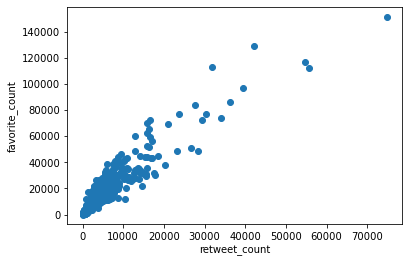

In [88]:
# A list contains values of retweet counts in master dataset
retweet_counts = master.retweet_count.values
# A list contains values of favorite counts in master dataset
favorite_counts = master.favorite_count.values
# Correlation coefficient between retweet counts and favorite counts
correl = master.retweet_count.corr(master.favorite_count)
print("The correlation coefficient between retweet_counts and favorite_counts: {}".format(correl))
# scatter plot between retweet counts and favorite counts
plt.scatter(retweet_counts, favorite_counts)
plt.xlabel('retweet_count')
plt.ylabel('favorite_count');

### Question 2
* What is the distribution of the ratings between the dogs?

#### Answer:

count    1961.000000
mean       10.537624
std         2.168708
min         0.000000
25%        10.000000
50%        11.000000
75%        12.000000
max        14.000000
Name: rating_numerator, dtype: float64

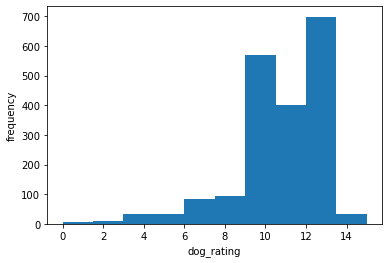

In [121]:
# Values of dog ratings
ratings = master.rating_numerator.values
# histogram plot
plt.hist(ratings, range=[0, 15])
plt.xlabel('dog_rating')
plt.ylabel('frequency')
# Five number summary for rating
master.rating_numerator.describe()

#### Question 3:
* What is the most frequency stage from dog_stages?

#### Answer:

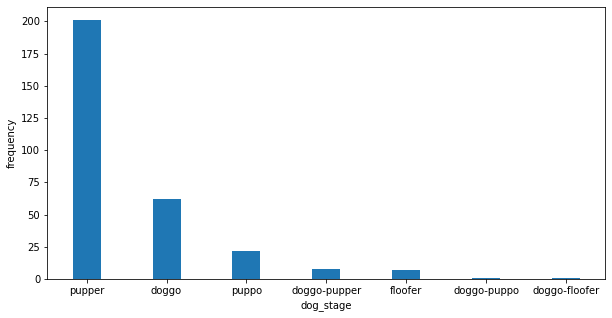

In [116]:
# Frequencies of dog_stages
dog_stages_freq = master.dog_stage.value_counts().values
# Names of dog_stages
dog_stages = master.dog_stage.value_counts().index
# Names of bar chart
locations = [i for i in range(len(dog_stages))]
# Bar plot
plt.bar(locations, dog_stages_freq, width=0.35, tick_label=dog_stages)
# Fig object
fig = plt.gcf()
# Setting figure size to 10 x 5 inch square
fig.set_size_inches(10,5)
plt.xlabel('dog_stage')
plt.ylabel('frequency');